# Código de preparación de datos para flujos de muones atmosféricos...

Este pequeño código prepara los datos para ser manipulados. Los datos provienen de la salida de muones despues del resultado de una simulación en Corsika para varias latitudes y modelos de atmósferas. La idea es manipular el primero de los archivos para obtener la energía total a partir de la consideración de los momentos en las direcciones $x$, $y$, y $z$. Lo segundo es teniendo la energía vamos a organizar los datos de tal manera de calcular el flujo diferencial, es decir, sumar todos los muones que llegan en la misma dirección para tener el número de muones que entran por esa determinada dirección, con esto tendremos una data de flujo por dirección.

In [1]:
import numpy as np
import math
import pandas as pd
from scipy.stats import itemfreq
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## We define several flux for atmospheric muons due several analytical models:

+ **Reyna/Bugaev (2002/1998) Model:** 

\begin{equation}
F_{RB}(\theta,E_0)=A_Bp_0^{-(a_3y^3+a_2y^2+a_1y^1+a_0)},
\end{equation}
con $p^2c^2=E_0^2-E_{rest}^2$, the rest mass of muon is $E_{rest}=0.10566$ GeV, $y=\log_{10}(p0)$, and $p_{0}=p\cos\theta$. The values of parameters are: $a_3=0.0209$, $a_2=-0.2555$, $a_1=1.288$, $a_0=0.2455$, and $A_B=0.00253$.

+ **Reyna/Hebbeker (2002/1998) Model:** 

\begin{equation}
F_{RH}(\theta,E_0)=A_H10^{h_1\frac{y^3-5y^2+6y}{2}+h_2\frac{-2y^3+9y^2-10y+3}{3}+h_3\frac{y^3-3y^2+2y}{6}+s_2\frac{y^3-6y^2+11y-6}{3}}.
\end{equation}
The values of parameters are: $h_1=0.133$, $h_2=-2.521$, $h_3=-5.78$ and $s_2=-2.11$, and $A_H=8.6\times 10^{-5}$.

+ **Tanaka (2008) Model:** 

\begin{equation}
F_{T}(\theta,E_0)=A_TW_{\mu}(Ep_0)^{-\gamma}\left(\frac{r_{\pi}^{-1}B_{\pi}\sec\theta}{Ep_0+B_{\pi}\sec\theta}+0.36b_r\frac{r_{k}^{-1}B_{k}\sec\theta}{Ep_0+B_{k}\sec\theta}\right),
\end{equation}
where $A_T=1.8\times 10^{-3}$, $\gamma=2.7$, $Ep_0:=E_0+\Delta E$, $\Delta E=2.6$, $r_k=0.52$, $r_{\pi}=0.78$, $B_{\pi}=90$ GeV, $B_{k}=442$ GeV, $b_r=0.635$.

+ **Gaisser/MUSIC (2008) Model:** 

\begin{equation}
F_{GM}(\theta,E_0)=A_{GM}(E_0)^{-\gamma}\left(\frac{1}{1+\frac{Ep_0\cos\theta}{E_{\pi}}}+\frac{G_0}{1+\frac{Ep_0\cos\theta}{E_{k}}}+r_{c}\right),
\end{equation}
where $A_{GM}=A_{G}\left(\frac{120\cos\phi}{1030}\right)^{\frac{1.04}{(E_{0}+\Delta E/2)\cos\phi}}$, $\gamma=2.7$, $A_G=0.14$, $Ep_0:=E_0+\Delta E$, $\Delta E=2.06\times 10^{-3}\left(\frac{1030}{\cos\phi}-120\right)$, $r_c=10^{-4}$, $B_{G}=0.054$, $E_{\pi}=115/1.1$ GeV, $E_{k}=850/1.1$ GeV, $\cos\phi=\sqrt{1-\frac{1-\cos^2\theta}{\left(1+\frac{H_{atm}}{R_{earth}}\right)^2}}$, moreover the exception that the substitution $E_0\rightarrow\frac{3E_0+7\sec\phi}{10}$.

In [2]:
# Definiendo el Flujo con modelo de Reyna(2006)/Bugaev(1998)
def Flujo_RB(theta,E0):
    c=1 #Light velocity (natural units)
    Emass=0.10566 #GeV
    R_earth=6370 #Km
    H_atm=32 #Km
    phi=np.arccos(np.sqrt(1-(1-np.cos(theta)**2)/(1+H_atm/R_earth)**2))
    p=np.sqrt((-Emass**2+E0**2)/c)
    p0=p*np.cos(theta)
    y=np.log10(p0)
    a0=0.2455
    a1=1.288
    a2=-0.2555
    a3=0.0209
    A_B=0.00253
    FB=A_B*p0**(-a3*y**3-a2*y**2-a1*y-a0)
    FRB=np.cos(theta)**3*FB
    return FRB

# Definiendo el Flujo con modelo de Reyna(2006)/Hebbeker(2002)
def Flujo_RH(theta,E0):
    c=1 #Light velocity (natural units)
    Emass=0.10566 #GeV
    R_earth=6370 #Km
    H_atm=32 #Km
    phi=np.arccos(np.sqrt(1-(1-np.cos(theta)**2)/(1+H_atm/R_earth)**2))
    p=np.sqrt((-Emass**2+E0**2)/c)
    p0=p*np.cos(theta)
    y=np.log10(p0)
    h1=0.133
    h2=-2.521
    h3=-5.78
    s2=-2.11
    A_H=8.6E-5
    H=h1*(y**3-5*y**2+6*y)/2+h2*(-2*y**3+9*y**2-10*y+3)/3+h3*(y**3-3*y**2+2*y)/6+s2*(y**3-6*y**2+11*y-6)/3
    FH=A_H*10**H
    FRH=np.cos(theta)**3*FH
    return FRH

# Definiendo el Flujo con modelo de Tanaka(2008)
def Flujo_T(theta,E0):
    W=0.5E2
    A_T=1.8E-3
    gamma=2.7
    DeltaE=2.6
    Ep0=E0+DeltaE
    rk=0.52
    rpi=0.78
    Bpi=90
    Bk=442
    br=0.635
    FT=A_T*W*Ep0**(-gamma)*((rpi**(-1)*Bpi*(np.cos(theta))**(-1))/(Ep0+Bpi*(np.cos(theta))**(-1))
                            +br*0.36*(rk**(-1)*Bk*(np.cos(theta))**(-1))/(Ep0+Bk*(np.cos(theta))**(-1)))
    return FT

# Definiendo el Flujo con modelo de Gaisser/MUSIC (Con parámetros de Lesparre)
def Flujo_GML(theta,E0):
    A_G=0.14
    r_c=1E-4
    B_G=0.054
    E_pi=115./1.1 #GeV
    E_k=850./1.1 #GeV
    c=1 #Light velocity (natural units)
    Emass=0.10566 #GeV
    R_earth=6370.0 #Km
    H_atm=32.0 #Km
    phi=np.arccos(np.sqrt(1.-((1.-np.cos(theta)**2)/((1.+H_atm/R_earth)**2))))
    DE=2.06E-3*((1030./np.cos(phi))-120.0)
    Ep_0=E0+DE
    A_GM=A_G*(120.*np.cos(phi)/1030.)**(1.04/((E0+DE/2.)*np.cos(phi)))
    gamma=2.7
    FGM=A_GM*E0**(-gamma)*((1./(1+((Ep_0*np.cos(theta))/E_pi)))+(B_G/(1+((Ep_0*np.cos(theta))/E_k)))+r_c)
    return FGML

# Definiendo el Flujo con modelo de Gaisser/MUSIC (Original)
def Flujo_GM(theta,E0):
    A_0=0.14
    r_c=1E-4
    B_G=0.054
    E_pi=115./1.1 #GeV
    E_k=850./1.1 #GeV
    c=1 #Light velocity (natural units)
    Emass=0.10566 #GeV
    R_earth=6370.0 #Km
    H_atm=32.0 #Km
    p1=0.102573
    p2=-0.068287
    p3=0.958633
    p4=0.0407253
    p5=0.817285
    phi=np.sqrt(((np.cos(theta))**2+p1**2+p2*(np.cos(theta))**(p3)+p4*(np.cos(theta))**(p5))/(1+p1**2+p2+p4))
    #phi=np.arccos(np.sqrt(1.-((1.-np.cos(theta)**2)/((1.+H_atm/R_earth)**2))))
    DE=2.06E-3*((950./np.cos(phi))-90.0)
    #E0q=((3*E0)+7./np.cos(phi))/10
    E0q=E0
    Ep_0=E0q+DE
    A_GM=A_0*1.1*(90.*np.sqrt(np.cos(phi)+0.001)/1030.)**(4.5/((E0q)*np.cos(phi)))
    gamma=2.7
    FGM=A_GM*(E0q)**(-gamma)*((1./(1+((Ep_0*np.cos(theta))/E_pi)))+(B_G/(1+((Ep_0*np.cos(theta))/E_k)))+r_c)
    return FGM

E0=np.linspace(1E0, 1E4, 1E4)

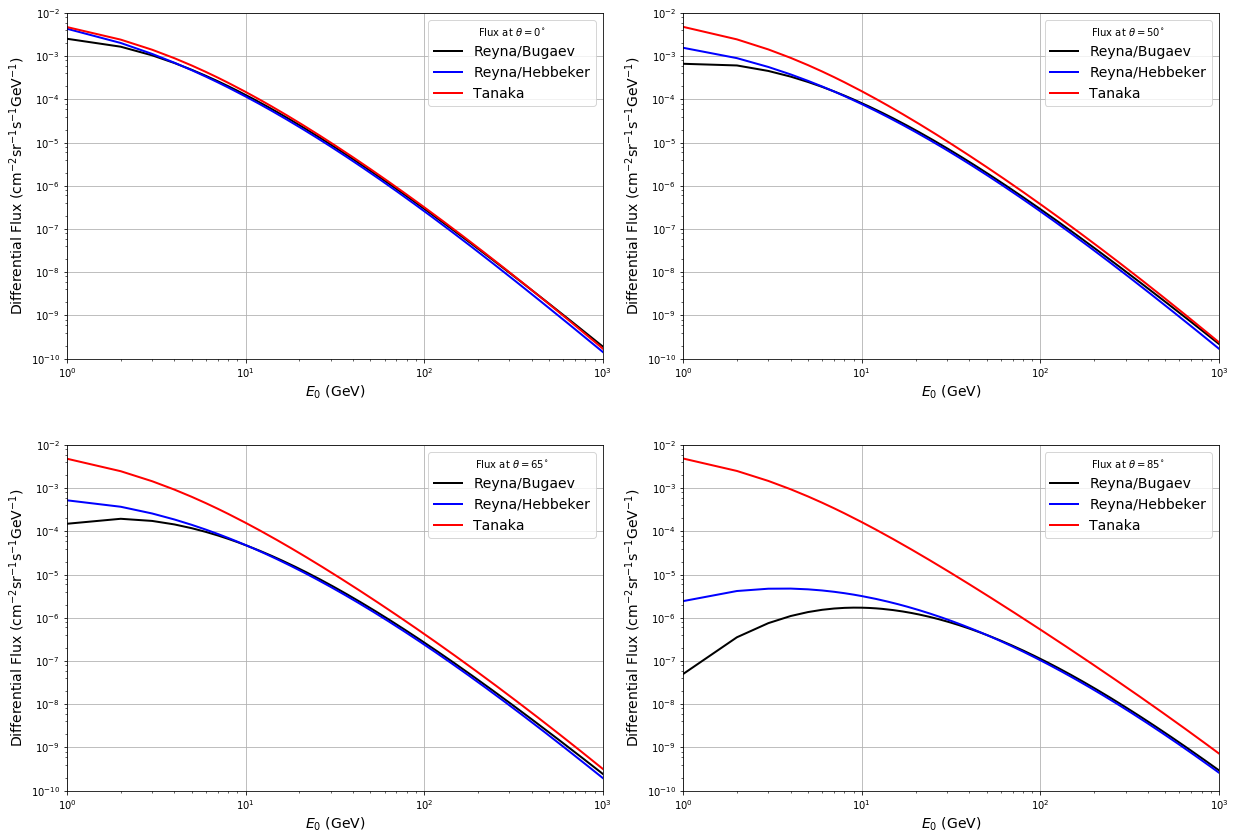

In [3]:
# Comparation of all fluxes...!
plt.figure(figsize=(8,12))
plt.subplot(221)
plt.plot(E0, Flujo_RB(np.radians(0),E0),'k',label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(0),E0),'b',label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(0),E0),'r',label='Tanaka',lw=2)
#plt.plot(E0, Flujo_GM(np.radians(0),E0),'orange',label='Gaisser/MUSIC',lw=2)
plt.legend(title=r'Flux at $\theta=$0$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1E0,1E3)
plt.ylim(1E-10,1E-2)

plt.subplot(222)
plt.plot(E0, Flujo_RB(np.radians(50),E0),'k',label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(50),E0),'b',label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(50),E0),'r',label='Tanaka',lw=2)
#plt.plot(E0, Flujo_GM(np.radians(50),E0),'orange',label='Gaisser/MUSIC',lw=2)
plt.legend(title=r'Flux at $\theta=$50$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1E0,1E3)
plt.ylim(1E-10,1E-2)

plt.subplot(223)
plt.plot(E0, Flujo_RB(np.radians(65),E0),'k',label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(65),E0),'b',label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(65),E0),'r',label='Tanaka',lw=2)
#plt.plot(E0, Flujo_GM(np.radians(65),E0),'orange',label='Gaisser/MUSIC',lw=2)
plt.legend(title=r'Flux at $\theta=$65$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1E0,1E3)
plt.ylim(1E-10,1E-2)

plt.subplot(224)
plt.plot(E0, Flujo_RB(np.radians(85),E0),'k',label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(85),E0),'b',label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(85),E0),'r',label='Tanaka',lw=2)
#plt.plot(E0, Flujo_GM(np.radians(85),E0),'orange',label='Gaisser/MUSIC',lw=2)
plt.legend(title=r'Flux at $\theta=$85$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1E0,1E3)
plt.ylim(1E-10,1E-2)

plt.subplots_adjust(top=0.9,bottom=0,left=0,right=2,hspace=0.25,wspace=0.15)
plt.show()

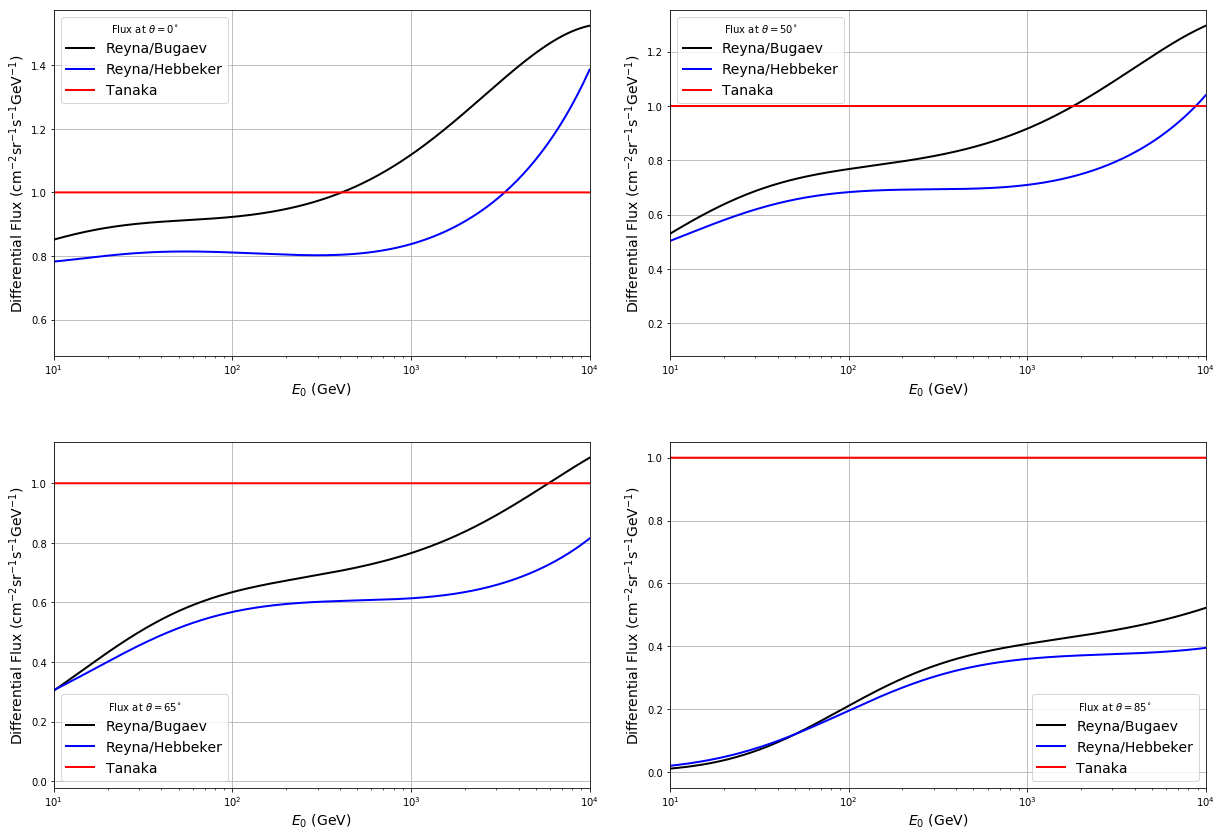

In [4]:
# Ratio of flux respect to Gaisser/MUSIC flux
plt.figure(figsize=(8,12))
plt.subplot(221)
plt.plot(E0, Flujo_RB(np.radians(0),E0)/Flujo_T(np.radians(0),E0),'k',label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(0),E0)/Flujo_T(np.radians(0),E0),'b',label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(0),E0)/Flujo_T(np.radians(0),E0),'r',label='Tanaka',lw=2)
#plt.plot(E0, Flujo_GM(np.radians(0),E0)/Flujo_GM(np.radians(0),E0),'orange',label='Gaisser/MUSIC',lw=2)
plt.legend(title=r'Flux at $\theta=$0$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
#plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1E1,1E4)

plt.subplot(222)
plt.plot(E0, Flujo_RB(np.radians(50),E0)/Flujo_T(np.radians(50),E0),'k',label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(50),E0)/Flujo_T(np.radians(50),E0),'b',label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(50),E0)/Flujo_T(np.radians(50),E0),'r',label='Tanaka',lw=2)
#plt.plot(E0, Flujo_GM(np.radians(50),E0)/Flujo_GM(np.radians(50),E0),'orange',label='Gaisser/MUSIC',lw=2)
plt.legend(title=r'Flux at $\theta=$50$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
#plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1E1,1E4)

plt.subplot(223)
plt.plot(E0, Flujo_RB(np.radians(65),E0)/Flujo_T(np.radians(65),E0),'k',label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(65),E0)/Flujo_T(np.radians(65),E0),'b',label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(65),E0)/Flujo_T(np.radians(65),E0),'r',label='Tanaka',lw=2)
#plt.plot(E0, Flujo_GM(np.radians(65),E0)/Flujo_GM(np.radians(65),E0),'orange',label='Gaisser/MUSIC',lw=2)
plt.legend(title=r'Flux at $\theta=$65$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
#plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1E1,1E4)

plt.subplot(224)
plt.plot(E0, Flujo_RB(np.radians(85),E0)/Flujo_T(np.radians(85),E0),'k',label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(85),E0)/Flujo_T(np.radians(85),E0),'b',label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(85),E0)/Flujo_T(np.radians(85),E0),'r',label='Tanaka',lw=2)
#plt.plot(E0, Flujo_GM(np.radians(85),E0)/Flujo_GM(np.radians(85),E0),'orange',label='Gaisser/MUSIC',lw=2)
plt.legend(title=r'Flux at $\theta=$85$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
#plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1E1,1E4)

plt.subplots_adjust(top=0.9,bottom=0,left=0,right=2,hspace=0.25,wspace=0.15)
plt.show()

Cargando los archivos de datos de corsika...

In [5]:
data_0_E1=np.loadtxt('muon_lat0_atmE1.out',delimiter=' ',usecols=range(3))
data_0_E2=np.loadtxt('muon_lat0_atmE2.out',delimiter=' ',usecols=range(3))
data_0_E3=np.loadtxt('muon_lat0_atmE3.out',delimiter=' ',usecols=range(3))
data_30N_E1=np.loadtxt('muon_lat30N_atmE1.out',delimiter=' ',usecols=range(3))
data_30N_E2=np.loadtxt('muon_lat30N_atmE2.out',delimiter=' ',usecols=range(3))
data_30N_E3=np.loadtxt('muon_lat30N_atmE3.out',delimiter=' ',usecols=range(3))
data_30S_E1=np.loadtxt('muon_lat30S_atmE1.out',delimiter=' ',usecols=range(3))
data_30S_E2=np.loadtxt('muon_lat30S_atmE2.out',delimiter=' ',usecols=range(3))
data_30S_E3=np.loadtxt('muon_lat30S_atmE3.out',delimiter=' ',usecols=range(3))

Defining a function of calculate Histograms of fluxes in each angular band...

In [6]:
def Flux(data,theta_i,theta_f):
    omega=1#2*np.pi #Solid angle of a Hemisphere
    factor=3600*1E4*omega #For convert m^-2*hour to cm^-2*s*sr^-1 divide for factor...!
    px,py,pz=data[:,0],data[:,1],data[:,2]
    p=np.sqrt(px**2+py**2+pz**2)
    m_rest=0.1057 #unit: GeV/c**2 #masa en reposo del muon
    E=np.round(np.sqrt(p**2+m_rest**2)) # Energía a partir de la masa en reposo del muon
    theta=np.round(np.degrees(np.arccos(pz/p)),decimals=0) # Calcula en angulo cenith
    at2=np.arctan2(py,px)
    phi=np.round(np.degrees((2*np.pi+at2)*(at2<0)+(at2)*(at2>0)),decimals=0) # Calcula el angulo azimuth
    data=np.c_[theta,phi,E]
    data=data[data[:,0].argsort()]
    E=data[(data[:,0]>=theta_i) & (data[:,0]<=theta_f)][:,2]
    F=np.unique(E)
    N=[]
    for i in F:
        N.append(np.sum(E==i))
    N=np.array(N)/(factor*F)
    Flux=np.c_[F,N]
    return Flux

In [7]:
def Flux_smooth(data,theta_i,theta_f):
    omega=2*np.pi #Solid angle of a Hemisphere
    factor=3600*1E4*omega #For convert m^-2*hour to cm^-2*s*sr^-1 divide for factor...!
    px,py,pz=data[:,0],data[:,1],data[:,2]
    p=np.sqrt(px**2+py**2+pz**2)
    m_rest=0.1057 #unit: GeV/c**2 #masa en reposo del muon
    E=np.round(np.sqrt(p**2+m_rest**2)) # Energía a partir de la masa en reposo del muon
    theta=np.round(np.degrees(np.arccos(pz/p)),decimals=0) # Calcula en angulo cenith
    at2=np.arctan2(py,px)
    phi=np.round(np.degrees((2*np.pi+at2)*(at2<0)+(at2)*(at2>0)),decimals=0) # Calcula el angulo azimuth
    data=np.c_[theta,phi,E]
    data=data[data[:,0].argsort()]
    E=data[(data[:,0]>=theta_i) & (data[:,0]<=theta_f)][:,2]
    F=np.unique(E)
    N=[]
    for i in F:
        N.append(np.sum(E==i))
    N=np.array(N)/(factor*F)
    Flux=np.c_[F,N]
    f=interp1d(Flux[:,0],Flux[:,1])#,kind='linear')
    xnew=np.linspace(1E0,1E3,num=301,endpoint=True)
    ynew=f(xnew)
    Flux_smooth=np.c_[xnew,ynew]
    return Flux_smooth

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


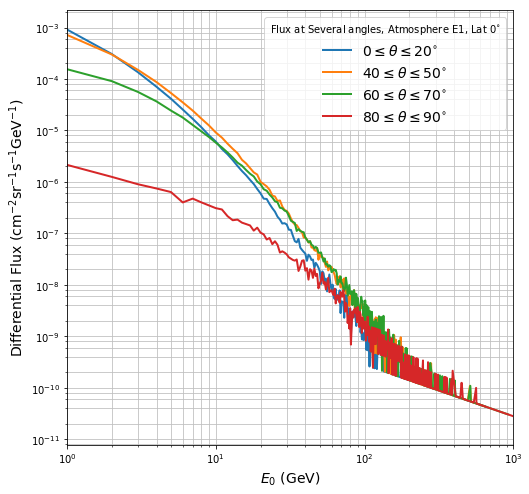

In [8]:
plt.figure(figsize=(8,8))
plt.plot(Flux(data_0_E1,0,20)[:,0],Flux(data_0_E1,0,20)[:,1],label=r'$0\leq\theta\leq20^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_0_E1,40,50)[:,0],Flux(data_0_E1,40,50)[:,1],label=r'$40\leq\theta\leq50^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_0_E1,60,70)[:,0],Flux(data_0_E1,60,70)[:,1],label=r'$60\leq\theta\leq70^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_0_E1,80,90)[:,0],Flux(data_0_E1,80,90)[:,1],label=r'$80\leq\theta\leq90^{\circ}$',lw=2)#,drawstyle='steps')

plt.legend(title=r'Flux at Several angles, Atmosphere E1, Lat 0$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
#plt.ylim(1E-11,2E-3)
plt.xlim(1E0,1E3)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


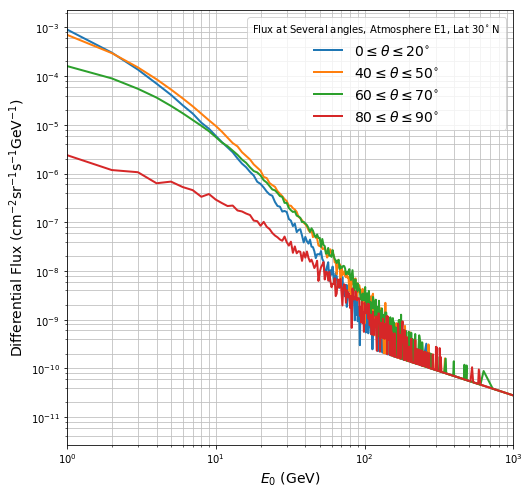

In [9]:
plt.figure(figsize=(8,8))
plt.plot(Flux(data_30N_E1,0,20)[:,0],Flux(data_30N_E1,0,20)[:,1],label=r'$0\leq\theta\leq20^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_30N_E1,40,50)[:,0],Flux(data_30N_E1,40,50)[:,1],label=r'$40\leq\theta\leq50^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_30N_E1,60,70)[:,0],Flux(data_30N_E1,60,70)[:,1],label=r'$60\leq\theta\leq70^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_30N_E1,80,90)[:,0],Flux(data_30N_E1,80,90)[:,1],label=r'$80\leq\theta\leq90^{\circ}$',lw=2)#,drawstyle='steps')

plt.legend(title=r'Flux at Several angles, Atmosphere E1, Lat 30$^{\circ}$ N',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
#plt.ylim(1E-12,1E-3)
plt.xlim(1E0,1E3)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


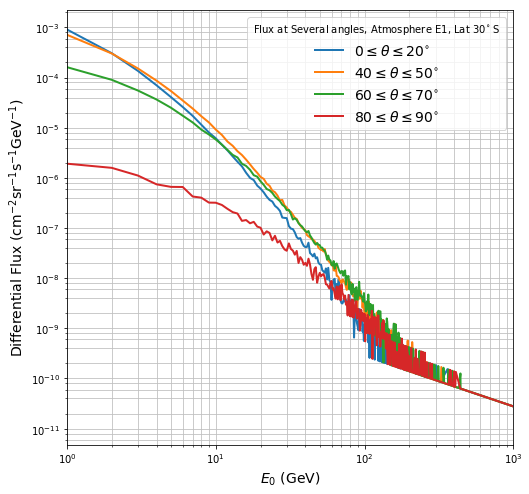

In [10]:
plt.figure(figsize=(8,8))
plt.plot(Flux(data_30S_E1,0,20)[:,0],Flux(data_30S_E1,0,20)[:,1],label=r'$0\leq\theta\leq20^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_30S_E1,40,50)[:,0],Flux(data_30S_E1,40,50)[:,1],label=r'$40\leq\theta\leq50^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_30S_E1,60,70)[:,0],Flux(data_30S_E1,60,70)[:,1],label=r'$60\leq\theta\leq70^{\circ}$',lw=2)#,drawstyle='steps')
plt.plot(Flux(data_30S_E1,80,90)[:,0],Flux(data_30S_E1,80,90)[:,1],label=r'$80\leq\theta\leq90^{\circ}$',lw=2)#,drawstyle='steps')
plt.legend(title=r'Flux at Several angles, Atmosphere E1, Lat 30$^{\circ}$ S',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
#plt.ylim(1E-12,1E-3)
plt.xlim(1E0,1E3)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


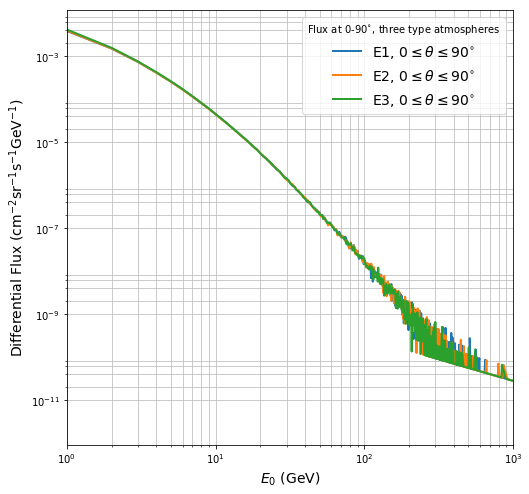

In [11]:
plt.figure(figsize=(8,8))
plt.plot(Flux(data_0_E1,0,90)[:,0],Flux(data_0_E1,0,90)[:,1],lw=2,label=r'E1, $0\leq\theta\leq90^{\circ}$')#,drawstyle='steps')
plt.plot(Flux(data_0_E2,0,90)[:,0],Flux(data_0_E2,0,90)[:,1],lw=2,label=r'E2, $0\leq\theta\leq90^{\circ}$')#,drawstyle='steps')
plt.plot(Flux(data_0_E3,0,90)[:,0],Flux(data_0_E3,0,90)[:,1],lw=2,label=r'E3, $0\leq\theta\leq90^{\circ}$')#,drawstyle='steps')

plt.legend(title=r'Flux at 0-90$^{\circ}$, three type atmospheres',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
#plt.ylim(1E-11,1E-2)
plt.xlim(1E0,1E3)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


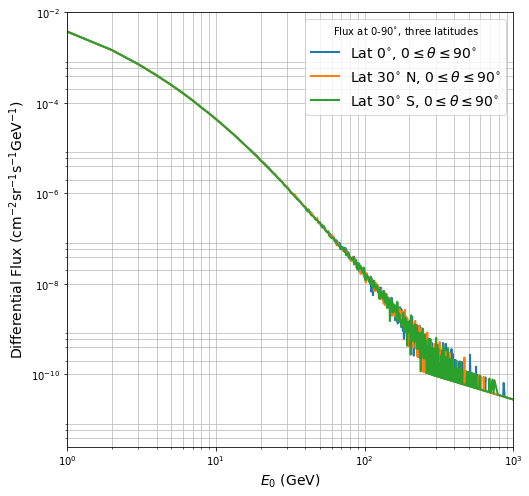

In [12]:
plt.figure(figsize=(8,8))
plt.plot(Flux(data_0_E1,0,90)[:,0],Flux(data_0_E1,0,90)[:,1],lw=2,label=r'Lat 0$^{\circ}$, $0\leq\theta\leq90^{\circ}$')#,drawstyle='steps')
plt.plot(Flux(data_30N_E1,0,90)[:,0],Flux(data_30N_E1,0,90)[:,1],lw=2,label=r'Lat 30$^{\circ}$ N, $0\leq\theta\leq90^{\circ}$')#,drawstyle='steps')
plt.plot(Flux(data_30S_E1,0,90)[:,0],Flux(data_30S_E1,0,90)[:,1],lw=2,label=r'Lat 30$^{\circ}$ S, $0\leq\theta\leq90^{\circ}$')#,drawstyle='steps')

plt.legend(title=r'Flux at 0-90$^{\circ}$, three latitudes',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
#plt.ylim(1E-11,1E-2)
plt.xlim(1E0,1E3)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


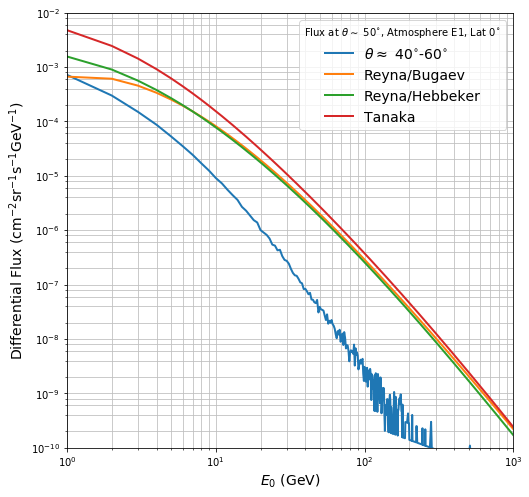

In [13]:
plt.figure(figsize=(8,8))
plt.plot(Flux(data_0_E1,40,50)[:,0],Flux(data_0_E1,40,50)[:,1],lw=2,label=r'$\theta\approx$ 40$^{\circ}$-60$^{\circ}$')#,drawstyle='steps')
plt.plot(E0, Flujo_RB(np.radians(50),E0),label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(50),E0),label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(50),E0),label='Tanaka',lw=2)
plt.legend(title=r'Flux at $\theta\sim$ 50$^{\circ}$, Atmosphere E1, Lat 0$^{\circ}$',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
plt.ylim(1E-10,1E-2)
plt.xlim(1E0,1E3)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


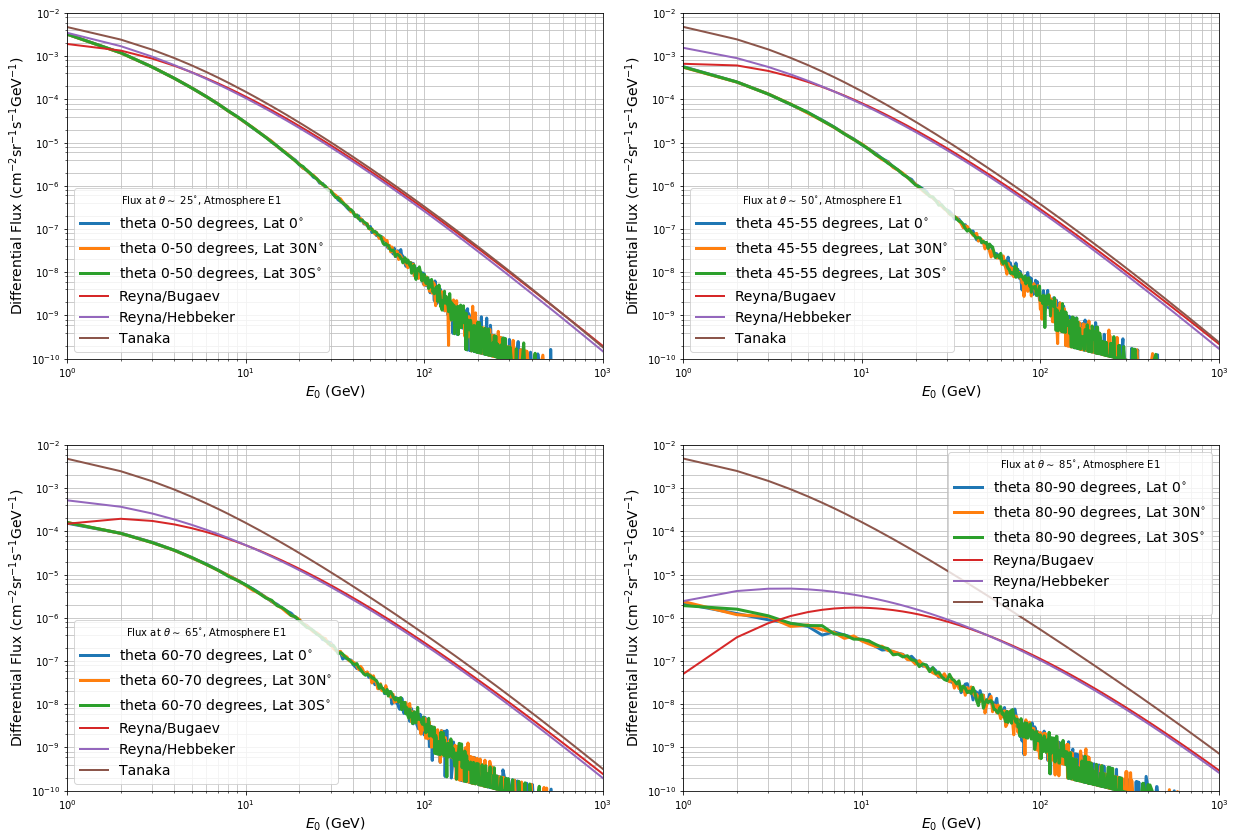

In [14]:
# Comparation of all fluxes...!
plt.figure(figsize=(8,12))
plt.subplot(221)
plt.plot(Flux(data_0_E1,0,50)[:,0],Flux(data_0_E1,0,50)[:,1],label='theta 0-50 degrees, Lat 0$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(Flux(data_30N_E1,0,50)[:,0],Flux(data_30N_E1,0,50)[:,1],label='theta 0-50 degrees, Lat 30N$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(Flux(data_30S_E1,0,50)[:,0],Flux(data_30S_E1,0,50)[:,1],label='theta 0-50 degrees, Lat 30S$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(E0, Flujo_RB(np.radians(25),E0),label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(25),E0),label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(25),E0),label='Tanaka',lw=2)
plt.legend(title=r'Flux at $\theta\sim$ 25$^{\circ}$, Atmosphere E1',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
plt.ylim(1E-10,1E-2)
plt.xlim(1E0,1E3)

plt.subplot(222)
plt.plot(Flux(data_0_E1,45,55)[:,0],Flux(data_0_E1,45,55)[:,1],label='theta 45-55 degrees, Lat 0$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(Flux(data_30N_E1,45,55)[:,0],Flux(data_30N_E1,45,55)[:,1],label='theta 45-55 degrees, Lat 30N$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(Flux(data_30S_E1,45,55)[:,0],Flux(data_30S_E1,45,55)[:,1],label='theta 45-55 degrees, Lat 30S$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(E0, Flujo_RB(np.radians(50),E0),label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(50),E0),label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(50),E0),label='Tanaka',lw=2)
plt.legend(title=r'Flux at $\theta\sim$ 50$^{\circ}$, Atmosphere E1',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
plt.ylim(1E-10,1E-2)
plt.xlim(1E0,1E3)

plt.subplot(223)
plt.plot(Flux(data_0_E1,60,70)[:,0],Flux(data_0_E1,60,70)[:,1],label='theta 60-70 degrees, Lat 0$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(Flux(data_30N_E1,60,70)[:,0],Flux(data_30N_E1,60,70)[:,1],label='theta 60-70 degrees, Lat 30N$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(Flux(data_30S_E1,60,70)[:,0],Flux(data_30S_E1,60,70)[:,1],label='theta 60-70 degrees, Lat 30S$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(E0, Flujo_RB(np.radians(65),E0),label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(65),E0),label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(65),E0),label='Tanaka',lw=2)
plt.legend(title=r'Flux at $\theta\sim$ 65$^{\circ}$, Atmosphere E1',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
plt.ylim(1E-10,1E-2)
plt.xlim(1E0,1E3)

plt.subplot(224)
plt.plot(Flux(data_0_E1,80,90)[:,0],Flux(data_0_E1,80,90)[:,1],label='theta 80-90 degrees, Lat 0$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(Flux(data_30N_E1,80,90)[:,0],Flux(data_30N_E1,80,90)[:,1],label='theta 80-90 degrees, Lat 30N$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(Flux(data_30S_E1,80,90)[:,0],Flux(data_30S_E1,80,90)[:,1],label='theta 80-90 degrees, Lat 30S$^{\circ}$',lw=3)#,drawstyle='steps')
plt.plot(E0, Flujo_RB(np.radians(85),E0),label='Reyna/Bugaev',lw=2)
plt.plot(E0, Flujo_RH(np.radians(85),E0),label='Reyna/Hebbeker',lw=2)
plt.plot(E0, Flujo_T(np.radians(85),E0),label='Tanaka',lw=2)
plt.legend(title=r'Flux at $\theta\sim$ 85$^{\circ}$, Atmosphere E1',loc='best',fontsize=14)
plt.ylabel(r'Differential Flux (cm$^{-2}$sr$^{-1}$s$^{-1}$GeV$^{-1}$)',fontsize=14)
plt.xlabel(r'$E_0$ (GeV)',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', color='0.75',linestyle='-')
plt.ylim(1E-10,1E-2)
plt.xlim(1E0,1E3)

plt.subplots_adjust(top=0.9,bottom=0,left=0,right=2,hspace=0.25,wspace=0.15)
plt.show()